In [1]:
# importando as bibliotecas necessárias 
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import matplotlib.pyplot as plt
from flaml import AutoML
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
import time 
import numpy as np
from statsmodels.tsa.seasonal import STL
from datetime import datetime 
from get_data import *

In [2]:
def tune_model(data, target, estimator=None, task='classification'):
    
    '''
    Aplica o  modelo de machine learning para diferentes estimadores
    Parameters
    ----------
    data : dataframe
        dataframe com as features que serão utilizadas no modelo
        
    target: array 
        array com o alvo do modelo

    Returns
    -------
    automl : 
         
        modelo de ML

    ''' 
    
    automl = AutoML()
    if estimator is not None:
        automl.fit(data, target, task="classification", estimator_list=[estimator])
    else:
        automl.fit(data, target, task="classification")
    return automl

In [16]:
target_curve_name = 'hosp'
canton = 'GE'
predictors = ['cases', 'hosp', 'test', 'hospcapacity']
vaccine = True
smooth= True
ini_date = '2020-03-01'

# compute the clusters 
clusters, all_regions,fig = compute_clusters('cases', t=0.8, plot = False)

for cluster in clusters:

    if canton in cluster:

        cluster_canton = cluster


# getting the data 
data = get_combined_data(predictors, cluster_canton, vaccine=vaccine, smooth = smooth)
# filling the nan values with 0
data = data.fillna(0)
    

# apply the model 

target_name = f'{target_curve_name}_{canton}'

maxlag = 21
T = 21

target_col = f'trend_{T}'

df_lag = build_lagged_features(data, maxlag=maxlag)
    
trend = [0 if t<=0 else 1 for t in np.sign(df_lag[target_name].shift(-T)-df_lag[target_name])]
df_lag[f'trend_{T}'] = trend#makes down trend 0 
df_lag = df_lag.dropna()
target = df_lag[target_col].copy()

del df_lag[target_col]

df_lag = df_lag.drop(data.columns, axis = 1)

X = df_lag
y = target 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, shuffle = False)

automl = tune_model(X_train, y_train)

lg = automl.best_model_for_estimator('lgbm')
rf = automl.best_model_for_estimator('rf')
et = automl.best_model_for_estimator('extra_tree')
xg = automl.best_model_for_estimator('xgboost')

vc = VotingClassifier(
estimators=[('lgbm', lg),('RF',rf),('XT',et),('Xgboost',xg)],
    voting='soft',)

vc.fit(X_train, y_train)
    
y_pred = vc.predict(X_test)
result = classification_report(y_test, y_pred, output_dict=True)

[flaml.automl: 01-09 23:32:40] {1928} INFO - task = classification
[flaml.automl: 01-09 23:32:40] {1930} INFO - Data split method: stratified
[flaml.automl: 01-09 23:32:40] {1934} INFO - Evaluation method: holdout
[flaml.automl: 01-09 23:32:40] {2004} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 01-09 23:32:40] {2056} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 01-09 23:32:40] {2296} INFO - iteration 0, current learner lgbm
[flaml.automl: 01-09 23:32:40] {2409} INFO - Estimated sufficient time budget=332s. Estimated necessary time budget=8s.
[flaml.automl: 01-09 23:32:40] {2484} INFO -  at 0.2s,	estimator lgbm's best error=0.1405,	best estimator lgbm's best error=0.1405
[flaml.automl: 01-09 23:32:40] {2296} INFO - iteration 1, current learner lgbm
[flaml.automl: 01-09 23:32:40] {2484} INFO -  at 0.2s,	estimator lgbm's best error=0.1338,	best estimator lgbm's best error=0.1338
[flaml.a

[flaml.automl: 01-09 23:32:41] {2296} INFO - iteration 36, current learner extra_tree
[flaml.automl: 01-09 23:32:41] {2484} INFO -  at 1.4s,	estimator extra_tree's best error=0.0769,	best estimator lgbm's best error=0.0192
[flaml.automl: 01-09 23:32:41] {2296} INFO - iteration 37, current learner xgboost
[flaml.automl: 01-09 23:32:41] {2484} INFO -  at 1.5s,	estimator xgboost's best error=0.0610,	best estimator lgbm's best error=0.0192
[flaml.automl: 01-09 23:32:41] {2296} INFO - iteration 38, current learner extra_tree
[flaml.automl: 01-09 23:32:41] {2484} INFO -  at 1.5s,	estimator extra_tree's best error=0.0769,	best estimator lgbm's best error=0.0192
[flaml.automl: 01-09 23:32:41] {2296} INFO - iteration 39, current learner rf
[flaml.automl: 01-09 23:32:41] {2484} INFO -  at 1.5s,	estimator rf's best error=0.0727,	best estimator lgbm's best error=0.0192
[flaml.automl: 01-09 23:32:41] {2296} INFO - iteration 40, current learner xgboost
[flaml.automl: 01-09 23:32:41] {2484} INFO -  a

[flaml.automl: 01-09 23:32:43] {2296} INFO - iteration 74, current learner xgboost
[flaml.automl: 01-09 23:32:43] {2484} INFO -  at 2.9s,	estimator xgboost's best error=0.0610,	best estimator lgbm's best error=0.0192
[flaml.automl: 01-09 23:32:43] {2296} INFO - iteration 75, current learner extra_tree
[flaml.automl: 01-09 23:32:43] {2484} INFO -  at 3.0s,	estimator extra_tree's best error=0.0368,	best estimator lgbm's best error=0.0192
[flaml.automl: 01-09 23:32:43] {2296} INFO - iteration 76, current learner lgbm
[flaml.automl: 01-09 23:32:43] {2484} INFO -  at 3.0s,	estimator lgbm's best error=0.0192,	best estimator lgbm's best error=0.0192
[flaml.automl: 01-09 23:32:43] {2296} INFO - iteration 77, current learner lgbm
[flaml.automl: 01-09 23:32:43] {2484} INFO -  at 3.0s,	estimator lgbm's best error=0.0192,	best estimator lgbm's best error=0.0192
[flaml.automl: 01-09 23:32:43] {2296} INFO - iteration 78, current learner extra_tree
[flaml.automl: 01-09 23:32:43] {2484} INFO -  at 3.1

[flaml.automl: 01-09 23:32:45] {2296} INFO - iteration 112, current learner xgboost
[flaml.automl: 01-09 23:32:45] {2484} INFO -  at 4.9s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0192
[flaml.automl: 01-09 23:32:45] {2296} INFO - iteration 113, current learner catboost
[flaml.automl: 01-09 23:32:45] {2484} INFO -  at 5.0s,	estimator catboost's best error=0.1739,	best estimator lgbm's best error=0.0192
[flaml.automl: 01-09 23:32:45] {2296} INFO - iteration 114, current learner extra_tree
[flaml.automl: 01-09 23:32:45] {2484} INFO -  at 5.1s,	estimator extra_tree's best error=0.0334,	best estimator lgbm's best error=0.0192
[flaml.automl: 01-09 23:32:45] {2296} INFO - iteration 115, current learner lgbm
[flaml.automl: 01-09 23:32:45] {2484} INFO -  at 5.1s,	estimator lgbm's best error=0.0192,	best estimator lgbm's best error=0.0192
[flaml.automl: 01-09 23:32:45] {2296} INFO - iteration 116, current learner lgbm
[flaml.automl: 01-09 23:32:45] {2484} INFO - 

[flaml.automl: 01-09 23:32:47] {2484} INFO -  at 6.9s,	estimator lgbm's best error=0.0117,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:47] {2296} INFO - iteration 151, current learner lgbm
[flaml.automl: 01-09 23:32:47] {2484} INFO -  at 6.9s,	estimator lgbm's best error=0.0117,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:47] {2296} INFO - iteration 152, current learner xgboost
[flaml.automl: 01-09 23:32:47] {2484} INFO -  at 7.0s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:47] {2296} INFO - iteration 153, current learner rf
[flaml.automl: 01-09 23:32:47] {2484} INFO -  at 7.0s,	estimator rf's best error=0.0318,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:47] {2296} INFO - iteration 154, current learner lgbm
[flaml.automl: 01-09 23:32:47] {2484} INFO -  at 7.0s,	estimator lgbm's best error=0.0117,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-0

[flaml.automl: 01-09 23:32:49] {2296} INFO - iteration 189, current learner lgbm
[flaml.automl: 01-09 23:32:49] {2484} INFO -  at 8.9s,	estimator lgbm's best error=0.0117,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:49] {2296} INFO - iteration 190, current learner xgboost
[flaml.automl: 01-09 23:32:49] {2484} INFO -  at 8.9s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:49] {2296} INFO - iteration 191, current learner lgbm
[flaml.automl: 01-09 23:32:49] {2484} INFO -  at 9.0s,	estimator lgbm's best error=0.0117,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:49] {2296} INFO - iteration 192, current learner catboost
[flaml.automl: 01-09 23:32:49] {2484} INFO -  at 9.1s,	estimator catboost's best error=0.1739,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:49] {2296} INFO - iteration 193, current learner rf
[flaml.automl: 01-09 23:32:49] {2484} INFO -  at 9.1s,	esti

[flaml.automl: 01-09 23:32:50] {2484} INFO -  at 10.6s,	estimator lgbm's best error=0.0117,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:50] {2296} INFO - iteration 228, current learner xgboost
[flaml.automl: 01-09 23:32:50] {2484} INFO -  at 10.6s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:50] {2296} INFO - iteration 229, current learner lgbm
[flaml.automl: 01-09 23:32:50] {2484} INFO -  at 10.6s,	estimator lgbm's best error=0.0117,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:50] {2296} INFO - iteration 230, current learner xgboost
[flaml.automl: 01-09 23:32:50] {2484} INFO -  at 10.7s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:50] {2296} INFO - iteration 231, current learner rf
[flaml.automl: 01-09 23:32:50] {2484} INFO -  at 10.7s,	estimator rf's best error=0.0242,	best estimator lgbm's best error=0.0117
[flaml.a

[flaml.automl: 01-09 23:32:52] {2296} INFO - iteration 266, current learner xgboost
[flaml.automl: 01-09 23:32:52] {2484} INFO -  at 12.6s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:52] {2296} INFO - iteration 267, current learner xgboost
[flaml.automl: 01-09 23:32:52] {2484} INFO -  at 12.7s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:52] {2296} INFO - iteration 268, current learner catboost
[flaml.automl: 01-09 23:32:52] {2484} INFO -  at 12.8s,	estimator catboost's best error=0.1739,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:52] {2296} INFO - iteration 269, current learner xgboost
[flaml.automl: 01-09 23:32:52] {2484} INFO -  at 12.8s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:52] {2296} INFO - iteration 270, current learner lgbm
[flaml.automl: 01-09 23:32:53] {2484} INF

[flaml.automl: 01-09 23:32:54] {2296} INFO - iteration 304, current learner lgbm
[flaml.automl: 01-09 23:32:54] {2484} INFO -  at 14.5s,	estimator lgbm's best error=0.0117,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:54] {2296} INFO - iteration 305, current learner xgboost
[flaml.automl: 01-09 23:32:54] {2484} INFO -  at 14.6s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:54] {2296} INFO - iteration 306, current learner xgboost
[flaml.automl: 01-09 23:32:54] {2484} INFO -  at 14.7s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:54] {2296} INFO - iteration 307, current learner catboost
[flaml.automl: 01-09 23:32:54] {2484} INFO -  at 14.8s,	estimator catboost's best error=0.1739,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:54] {2296} INFO - iteration 308, current learner rf
[flaml.automl: 01-09 23:32:54] {2484} INFO -  at 

[flaml.automl: 01-09 23:32:56] {2484} INFO -  at 16.1s,	estimator lgbm's best error=0.0117,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:56] {2296} INFO - iteration 342, current learner catboost
[flaml.automl: 01-09 23:32:56] {2484} INFO -  at 16.2s,	estimator catboost's best error=0.1739,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:56] {2296} INFO - iteration 343, current learner xgb_limitdepth
[flaml.automl: 01-09 23:32:56] {2484} INFO -  at 16.2s,	estimator xgb_limitdepth's best error=0.0627,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:56] {2296} INFO - iteration 344, current learner xgb_limitdepth
[flaml.automl: 01-09 23:32:56] {2484} INFO -  at 16.3s,	estimator xgb_limitdepth's best error=0.0627,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:56] {2296} INFO - iteration 345, current learner xgboost
[flaml.automl: 01-09 23:32:56] {2484} INFO -  at 16.3s,	estimator xgboost's best error=0.0284,	be

[flaml.automl: 01-09 23:32:57] {2484} INFO -  at 17.6s,	estimator lgbm's best error=0.0117,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:57] {2296} INFO - iteration 379, current learner extra_tree
[flaml.automl: 01-09 23:32:57] {2484} INFO -  at 17.7s,	estimator extra_tree's best error=0.0334,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:57] {2296} INFO - iteration 380, current learner lgbm
[flaml.automl: 01-09 23:32:57] {2484} INFO -  at 17.7s,	estimator lgbm's best error=0.0117,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:57] {2296} INFO - iteration 381, current learner rf
[flaml.automl: 01-09 23:32:57] {2484} INFO -  at 17.7s,	estimator rf's best error=0.0217,	best estimator lgbm's best error=0.0117
[flaml.automl: 01-09 23:32:57] {2296} INFO - iteration 382, current learner xgb_limitdepth
[flaml.automl: 01-09 23:32:57] {2484} INFO -  at 17.8s,	estimator xgb_limitdepth's best error=0.0468,	best estimator lgbm's best e

[flaml.automl: 01-09 23:32:59] {2296} INFO - iteration 416, current learner lgbm
[flaml.automl: 01-09 23:32:59] {2484} INFO -  at 19.5s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:32:59] {2296} INFO - iteration 417, current learner xgboost
[flaml.automl: 01-09 23:32:59] {2484} INFO -  at 19.5s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:32:59] {2296} INFO - iteration 418, current learner extra_tree
[flaml.automl: 01-09 23:32:59] {2484} INFO -  at 19.6s,	estimator extra_tree's best error=0.0334,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:32:59] {2296} INFO - iteration 419, current learner xgboost
[flaml.automl: 01-09 23:32:59] {2484} INFO -  at 19.6s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:32:59] {2296} INFO - iteration 420, current learner extra_tree
[flaml.automl: 01-09 23:32:59] {2484}

[flaml.automl: 01-09 23:33:01] {2296} INFO - iteration 454, current learner lgbm
[flaml.automl: 01-09 23:33:01] {2484} INFO -  at 21.2s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:01] {2296} INFO - iteration 455, current learner lgbm
[flaml.automl: 01-09 23:33:01] {2484} INFO -  at 21.3s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:01] {2296} INFO - iteration 456, current learner lgbm
[flaml.automl: 01-09 23:33:01] {2484} INFO -  at 21.3s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:01] {2296} INFO - iteration 457, current learner xgboost
[flaml.automl: 01-09 23:33:01] {2484} INFO -  at 21.3s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:01] {2296} INFO - iteration 458, current learner xgb_limitdepth
[flaml.automl: 01-09 23:33:01] {2484} INFO -  at 21

[flaml.automl: 01-09 23:33:03] {2296} INFO - iteration 492, current learner lgbm
[flaml.automl: 01-09 23:33:03] {2484} INFO -  at 23.0s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:03] {2296} INFO - iteration 493, current learner lgbm
[flaml.automl: 01-09 23:33:03] {2484} INFO -  at 23.0s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:03] {2296} INFO - iteration 494, current learner catboost
[flaml.automl: 01-09 23:33:03] {2484} INFO -  at 23.1s,	estimator catboost's best error=0.1739,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:03] {2296} INFO - iteration 495, current learner lgbm
[flaml.automl: 01-09 23:33:03] {2484} INFO -  at 23.2s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:03] {2296} INFO - iteration 496, current learner rf
[flaml.automl: 01-09 23:33:03] {2484} INFO -  at 23.2s,	estim

[flaml.automl: 01-09 23:33:04] {2296} INFO - iteration 530, current learner catboost
[flaml.automl: 01-09 23:33:04] {2484} INFO -  at 24.8s,	estimator catboost's best error=0.1739,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:04] {2296} INFO - iteration 531, current learner lgbm
[flaml.automl: 01-09 23:33:04] {2484} INFO -  at 24.8s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:04] {2296} INFO - iteration 532, current learner lgbm
[flaml.automl: 01-09 23:33:05] {2484} INFO -  at 24.9s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:05] {2296} INFO - iteration 533, current learner lgbm
[flaml.automl: 01-09 23:33:05] {2484} INFO -  at 24.9s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:05] {2296} INFO - iteration 534, current learner lgbm
[flaml.automl: 01-09 23:33:05] {2484} INFO -  at 24.9s,	est

[flaml.automl: 01-09 23:33:06] {2296} INFO - iteration 568, current learner xgboost
[flaml.automl: 01-09 23:33:06] {2484} INFO -  at 26.4s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:06] {2296} INFO - iteration 569, current learner lgbm
[flaml.automl: 01-09 23:33:06] {2484} INFO -  at 26.5s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:06] {2296} INFO - iteration 570, current learner xgboost
[flaml.automl: 01-09 23:33:06] {2484} INFO -  at 26.5s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:06] {2296} INFO - iteration 571, current learner xgboost
[flaml.automl: 01-09 23:33:06] {2484} INFO -  at 26.6s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:06] {2296} INFO - iteration 572, current learner lgbm
[flaml.automl: 01-09 23:33:06] {2484} INFO -  at 

[flaml.automl: 01-09 23:33:08] {2296} INFO - iteration 606, current learner xgboost
[flaml.automl: 01-09 23:33:08] {2484} INFO -  at 28.3s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:08] {2296} INFO - iteration 607, current learner extra_tree
[flaml.automl: 01-09 23:33:08] {2484} INFO -  at 28.3s,	estimator extra_tree's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:08] {2296} INFO - iteration 608, current learner lgbm
[flaml.automl: 01-09 23:33:08] {2484} INFO -  at 28.3s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:08] {2296} INFO - iteration 609, current learner lgbm
[flaml.automl: 01-09 23:33:08] {2484} INFO -  at 28.4s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:08] {2296} INFO - iteration 610, current learner lgbm
[flaml.automl: 01-09 23:33:08] {2484} INFO -  at 

[flaml.automl: 01-09 23:33:10] {2296} INFO - iteration 644, current learner lgbm
[flaml.automl: 01-09 23:33:10] {2484} INFO -  at 30.0s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:10] {2296} INFO - iteration 645, current learner lgbm
[flaml.automl: 01-09 23:33:10] {2484} INFO -  at 30.1s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:10] {2296} INFO - iteration 646, current learner lgbm
[flaml.automl: 01-09 23:33:10] {2484} INFO -  at 30.1s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:10] {2296} INFO - iteration 647, current learner extra_tree
[flaml.automl: 01-09 23:33:10] {2484} INFO -  at 30.1s,	estimator extra_tree's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:10] {2296} INFO - iteration 648, current learner lgbm
[flaml.automl: 01-09 23:33:10] {2484} INFO -  at 30.2s,

[flaml.automl: 01-09 23:33:12] {2296} INFO - iteration 682, current learner lgbm
[flaml.automl: 01-09 23:33:12] {2484} INFO -  at 32.0s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:12] {2296} INFO - iteration 683, current learner lgbm
[flaml.automl: 01-09 23:33:12] {2484} INFO -  at 32.0s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:12] {2296} INFO - iteration 684, current learner xgb_limitdepth
[flaml.automl: 01-09 23:33:12] {2484} INFO -  at 32.1s,	estimator xgb_limitdepth's best error=0.0435,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:12] {2296} INFO - iteration 685, current learner extra_tree
[flaml.automl: 01-09 23:33:12] {2484} INFO -  at 32.1s,	estimator extra_tree's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:12] {2296} INFO - iteration 686, current learner xgboost
[flaml.automl: 01-09 23:33:12] {

[flaml.automl: 01-09 23:33:13] {2296} INFO - iteration 720, current learner extra_tree
[flaml.automl: 01-09 23:33:13] {2484} INFO -  at 33.7s,	estimator extra_tree's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:13] {2296} INFO - iteration 721, current learner rf
[flaml.automl: 01-09 23:33:13] {2484} INFO -  at 33.7s,	estimator rf's best error=0.0217,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:13] {2296} INFO - iteration 722, current learner extra_tree
[flaml.automl: 01-09 23:33:13] {2484} INFO -  at 33.8s,	estimator extra_tree's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:13] {2296} INFO - iteration 723, current learner rf
[flaml.automl: 01-09 23:33:13] {2484} INFO -  at 33.8s,	estimator rf's best error=0.0217,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:13] {2296} INFO - iteration 724, current learner xgboost
[flaml.automl: 01-09 23:33:14] {2484} INFO -  at

[flaml.automl: 01-09 23:33:15] {2484} INFO -  at 35.6s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:15] {2296} INFO - iteration 758, current learner xgb_limitdepth
[flaml.automl: 01-09 23:33:15] {2484} INFO -  at 35.6s,	estimator xgb_limitdepth's best error=0.0435,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:15] {2296} INFO - iteration 759, current learner extra_tree
[flaml.automl: 01-09 23:33:15] {2484} INFO -  at 35.6s,	estimator extra_tree's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:15] {2296} INFO - iteration 760, current learner catboost
[flaml.automl: 01-09 23:33:15] {2484} INFO -  at 35.7s,	estimator catboost's best error=0.1739,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:15] {2296} INFO - iteration 761, current learner extra_tree
[flaml.automl: 01-09 23:33:15] {2484} INFO -  at 35.8s,	estimator extra_tree's best error=0.0284,	best

[flaml.automl: 01-09 23:33:17] {2296} INFO - iteration 794, current learner lrl1
/opt/anaconda3/envs/swiss_covid19/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[flaml.automl: 01-09 23:33:17] {2484} INFO -  at 37.8s,	estimator lrl1's best error=0.3595,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:17] {2296} INFO - iteration 795, current learner xgboost
[flaml.automl: 01-09 23:33:17] {2484} INFO -  at 37.8s,	estimator xgboost's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:17] {2296} INFO - iteration 796, current learner lrl1
/opt/anaconda3/envs/swiss_covid19/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[flaml.automl: 01-09 23:33:18] {2484} INFO -  at 38.0s,	estimator lrl1's best error=0.3595,	b

[flaml.automl: 01-09 23:33:20] {2296} INFO - iteration 822, current learner lgbm
[flaml.automl: 01-09 23:33:20] {2484} INFO -  at 40.7s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:20] {2296} INFO - iteration 823, current learner catboost
[flaml.automl: 01-09 23:33:20] {2484} INFO -  at 40.8s,	estimator catboost's best error=0.1739,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:20] {2296} INFO - iteration 824, current learner lgbm
[flaml.automl: 01-09 23:33:21] {2484} INFO -  at 40.9s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:21] {2296} INFO - iteration 825, current learner lrl1
/opt/anaconda3/envs/swiss_covid19/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[flaml.automl: 01-09 23:33:21] {2484} INFO -  at 41.1s,	estimator lrl1's be

[flaml.automl: 01-09 23:33:23] {2296} INFO - iteration 856, current learner rf
[flaml.automl: 01-09 23:33:23] {2484} INFO -  at 43.2s,	estimator rf's best error=0.0217,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:23] {2296} INFO - iteration 857, current learner lrl1
/opt/anaconda3/envs/swiss_covid19/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[flaml.automl: 01-09 23:33:23] {2484} INFO -  at 43.4s,	estimator lrl1's best error=0.3595,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:23] {2296} INFO - iteration 858, current learner extra_tree
[flaml.automl: 01-09 23:33:23] {2484} INFO -  at 43.4s,	estimator extra_tree's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:23] {2296} INFO - iteration 859, current learner extra_tree
[flaml.automl: 01-09 23:33:23] {2484} INFO -  at 43.5s,	estimator ext

[flaml.automl: 01-09 23:33:25] {2484} INFO -  at 45.7s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:25] {2296} INFO - iteration 889, current learner xgb_limitdepth
[flaml.automl: 01-09 23:33:25] {2484} INFO -  at 45.7s,	estimator xgb_limitdepth's best error=0.0435,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:25] {2296} INFO - iteration 890, current learner rf
[flaml.automl: 01-09 23:33:25] {2484} INFO -  at 45.7s,	estimator rf's best error=0.0217,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:25] {2296} INFO - iteration 891, current learner lrl1
/opt/anaconda3/envs/swiss_covid19/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[flaml.automl: 01-09 23:33:26] {2484} INFO -  at 45.9s,	estimator lrl1's best error=0.3595,	best estimator lgbm's best error=0.0100
[flaml.automl: 0

[flaml.automl: 01-09 23:33:28] {2296} INFO - iteration 921, current learner lrl1
/opt/anaconda3/envs/swiss_covid19/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[flaml.automl: 01-09 23:33:28] {2484} INFO -  at 48.5s,	estimator lrl1's best error=0.3595,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:28] {2296} INFO - iteration 922, current learner catboost
[flaml.automl: 01-09 23:33:28] {2484} INFO -  at 48.6s,	estimator catboost's best error=0.1739,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:28] {2296} INFO - iteration 923, current learner extra_tree
[flaml.automl: 01-09 23:33:28] {2484} INFO -  at 48.6s,	estimator extra_tree's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:28] {2296} INFO - iteration 924, current learner xgb_limitdepth
[flaml.automl: 01-09 23:33:28] {2484} INFO -  at 48.7

[flaml.automl: 01-09 23:33:30] {2296} INFO - iteration 956, current learner rf
[flaml.automl: 01-09 23:33:30] {2484} INFO -  at 50.6s,	estimator rf's best error=0.0217,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:30] {2296} INFO - iteration 957, current learner rf
[flaml.automl: 01-09 23:33:30] {2484} INFO -  at 50.6s,	estimator rf's best error=0.0217,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:30] {2296} INFO - iteration 958, current learner extra_tree
[flaml.automl: 01-09 23:33:30] {2484} INFO -  at 50.7s,	estimator extra_tree's best error=0.0284,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:30] {2296} INFO - iteration 959, current learner lgbm
[flaml.automl: 01-09 23:33:30] {2484} INFO -  at 50.7s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:30] {2296} INFO - iteration 960, current learner lgbm
[flaml.automl: 01-09 23:33:30] {2484} INFO -  at 50.7s,	estimat

[flaml.automl: 01-09 23:33:33] {2296} INFO - iteration 989, current learner lrl1
/opt/anaconda3/envs/swiss_covid19/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[flaml.automl: 01-09 23:33:33] {2484} INFO -  at 53.2s,	estimator lrl1's best error=0.3595,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:33] {2296} INFO - iteration 990, current learner lgbm
[flaml.automl: 01-09 23:33:33] {2484} INFO -  at 53.2s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:33] {2296} INFO - iteration 991, current learner rf
[flaml.automl: 01-09 23:33:33] {2484} INFO -  at 53.3s,	estimator rf's best error=0.0217,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:33] {2296} INFO - iteration 992, current learner xgboost
[flaml.automl: 01-09 23:33:33] {2484} INFO -  at 53.3s,	estimator xgboost's best err

[flaml.automl: 01-09 23:33:35] {2296} INFO - iteration 1022, current learner lgbm
[flaml.automl: 01-09 23:33:35] {2484} INFO -  at 55.5s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:35] {2296} INFO - iteration 1023, current learner lgbm
[flaml.automl: 01-09 23:33:35] {2484} INFO -  at 55.6s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:35] {2296} INFO - iteration 1024, current learner rf
[flaml.automl: 01-09 23:33:35] {2484} INFO -  at 55.6s,	estimator rf's best error=0.0217,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:35] {2296} INFO - iteration 1025, current learner lgbm
[flaml.automl: 01-09 23:33:35] {2484} INFO -  at 55.6s,	estimator lgbm's best error=0.0100,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:35] {2296} INFO - iteration 1026, current learner extra_tree
[flaml.automl: 01-09 23:33:35] {2484} INFO -  at 55.7s,	esti

[flaml.automl: 01-09 23:33:38] {2296} INFO - iteration 1054, current learner rf
[flaml.automl: 01-09 23:33:38] {2484} INFO -  at 58.1s,	estimator rf's best error=0.0217,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:38] {2296} INFO - iteration 1055, current learner lrl1
/opt/anaconda3/envs/swiss_covid19/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[flaml.automl: 01-09 23:33:38] {2484} INFO -  at 58.3s,	estimator lrl1's best error=0.3595,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:38] {2296} INFO - iteration 1056, current learner catboost
[flaml.automl: 01-09 23:33:38] {2484} INFO -  at 58.4s,	estimator catboost's best error=0.1739,	best estimator lgbm's best error=0.0100
[flaml.automl: 01-09 23:33:38] {2296} INFO - iteration 1057, current learner lgbm
[flaml.automl: 01-09 23:33:38] {2484} INFO -  at 58.5s,	estimator lgbm's be

In [18]:
result

{'0': {'precision': 0.48514851485148514,
  'recall': 0.98,
  'f1-score': 0.6490066225165563,
  'support': 50},
 '1': {'precision': 0.9818181818181818,
  'recall': 0.5094339622641509,
  'f1-score': 0.670807453416149,
  'support': 106},
 'accuracy': 0.6602564102564102,
 'macro avg': {'precision': 0.7334833483348335,
  'recall': 0.7447169811320755,
  'f1-score': 0.6599070379663526,
  'support': 156},
 'weighted avg': {'precision': 0.8226291859955227,
  'recall': 0.6602564102564102,
  'f1-score': 0.6638200076149975,
  'support': 156}}

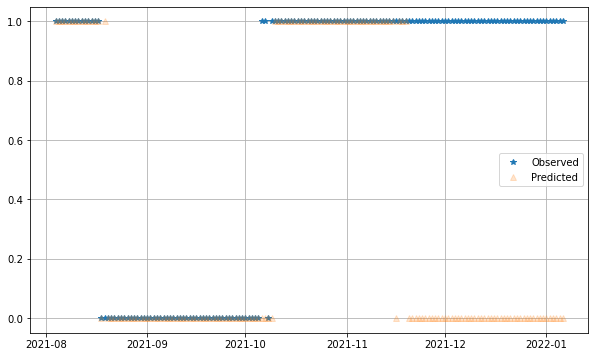

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(y_test, '*', label='Observed')
ax.plot(y_test.index,y_pred,'^', alpha=0.2, label='Predicted')
plt.grid()
plt.legend(loc=0);

/opt/anaconda3/envs/swiss_covid19/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/swiss_covid19/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/swiss_covid19/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 

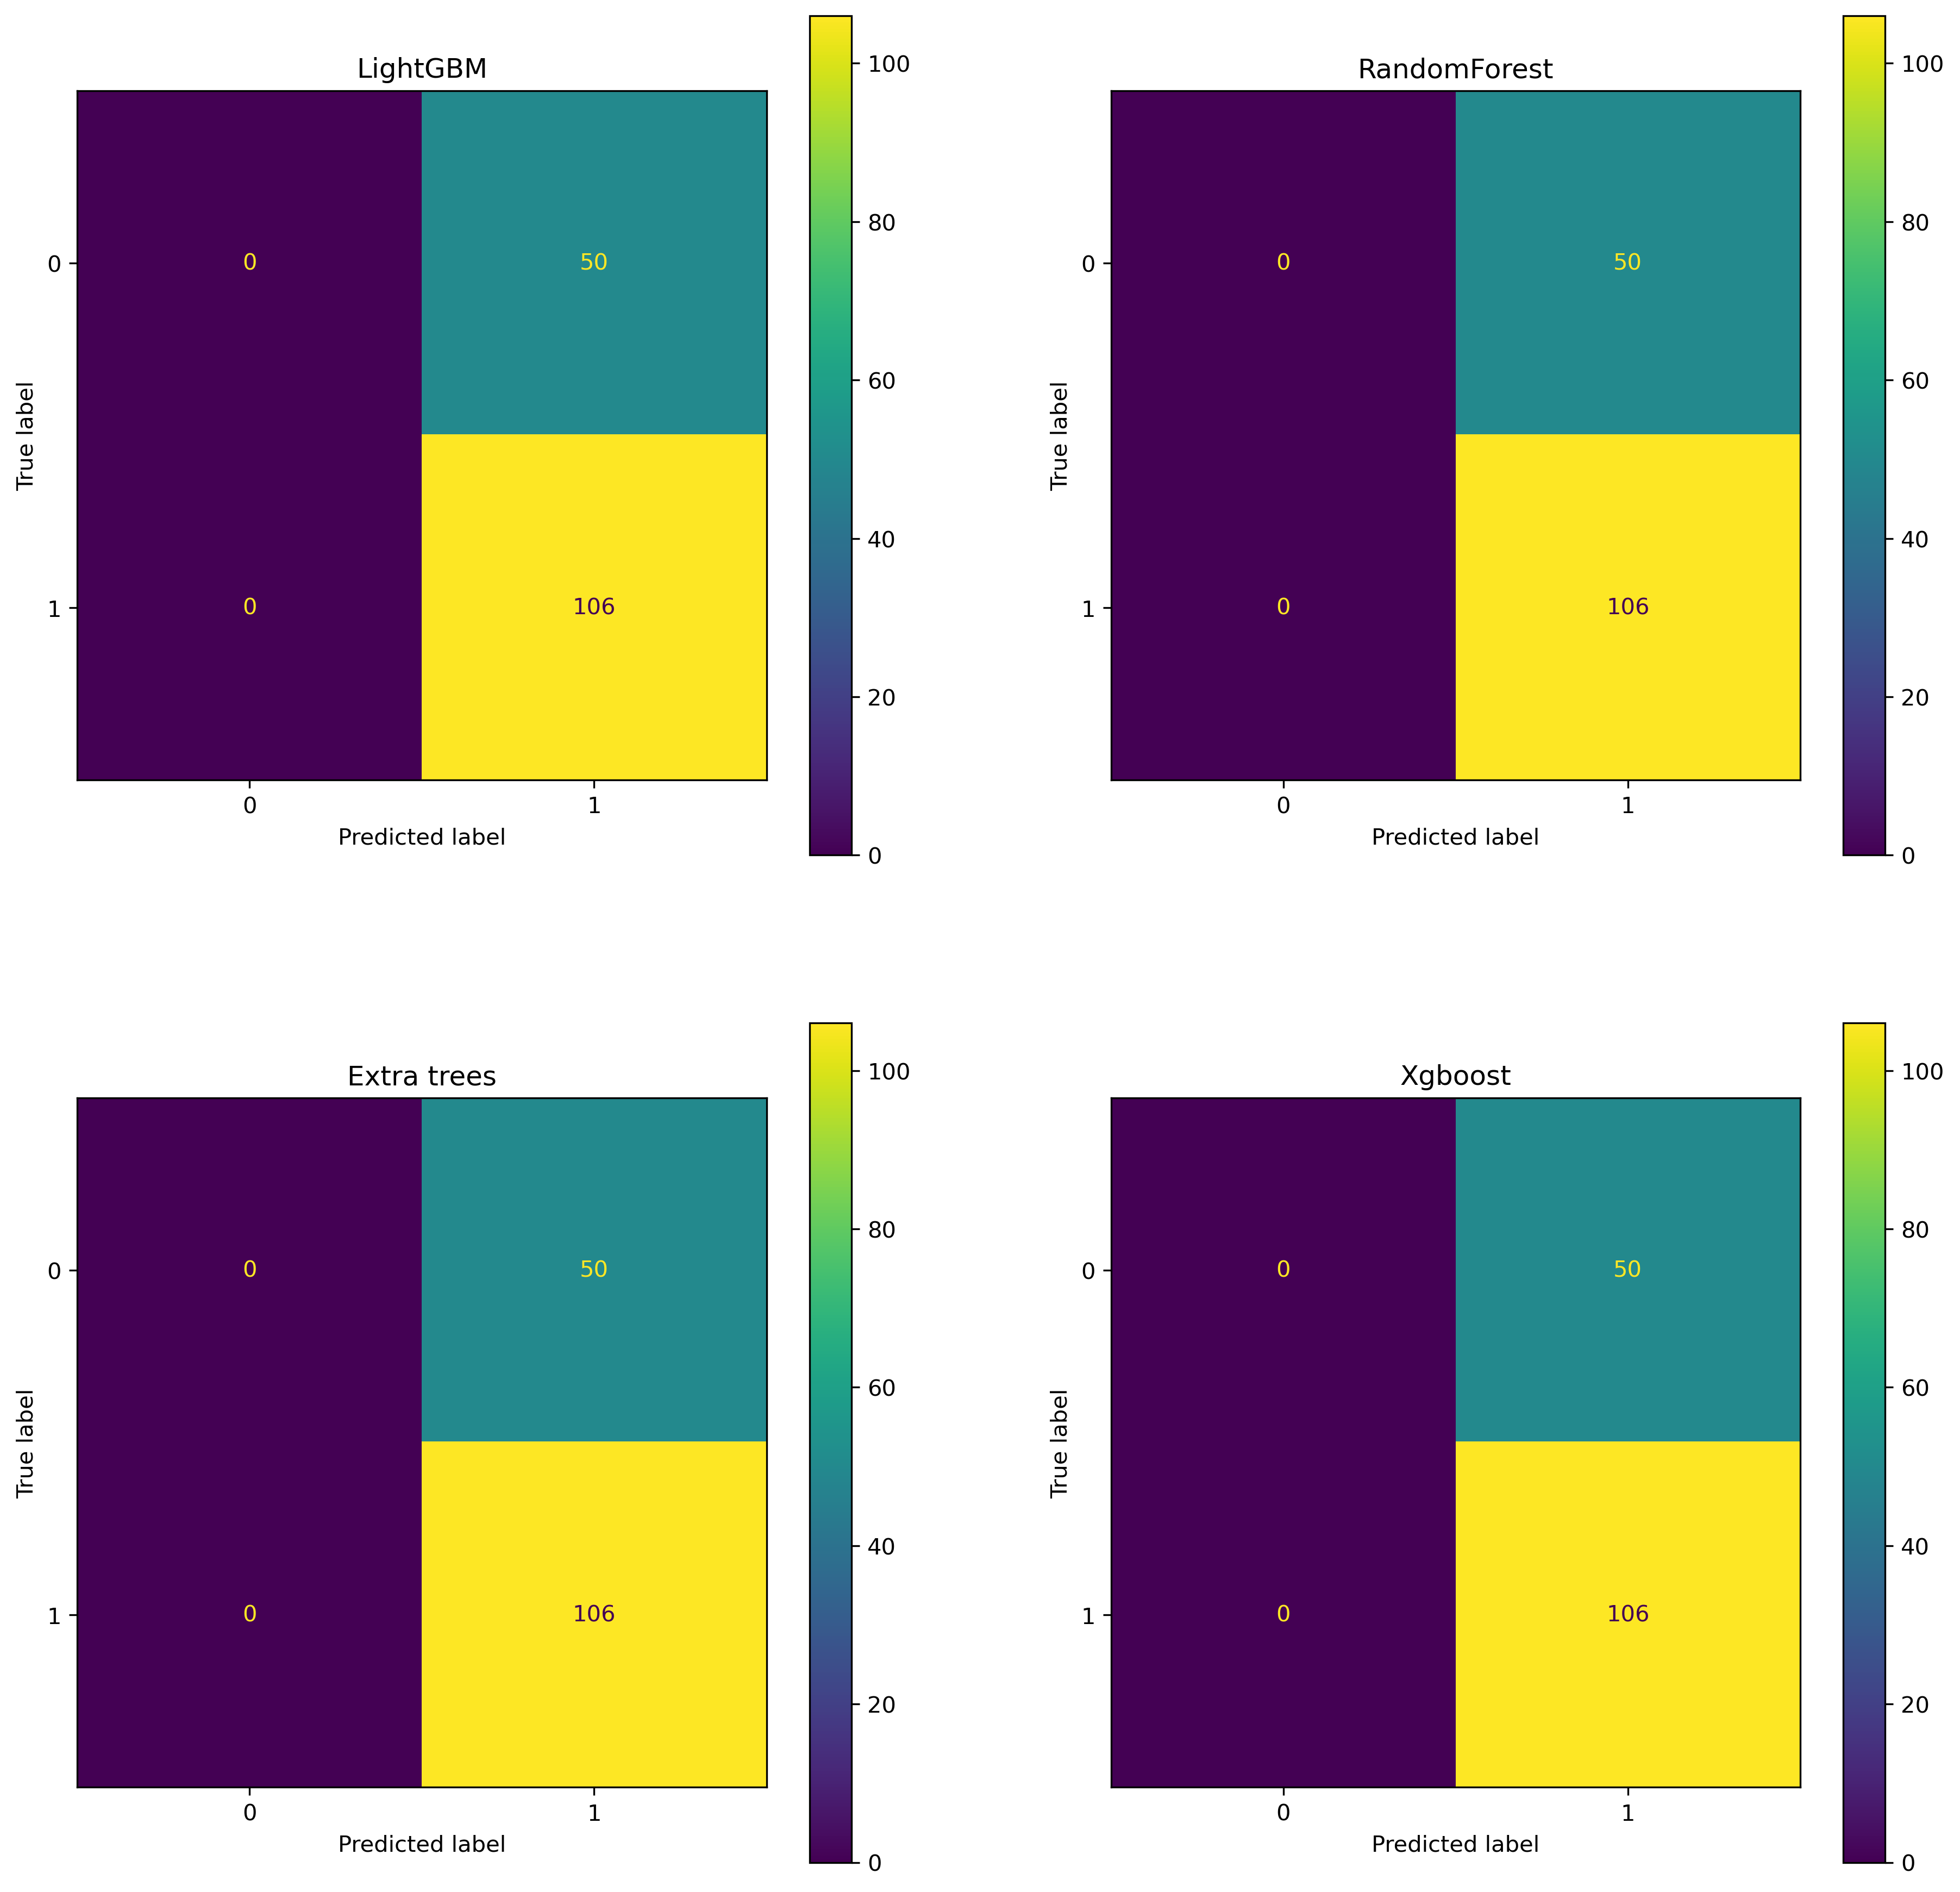

In [20]:
fig,ax = plt.subplots(2,2, figsize=(15,15), dpi = 300)
plot_confusion_matrix(lg,X_test, y_test,ax=ax[0,0]);
ax[0,0].set_title('LightGBM')
plot_confusion_matrix(rf,X_test, y_test,ax=ax[0,1]);
ax[0,1].set_title('RandomForest')
plot_confusion_matrix(et,X_test, y_test,ax=ax[1,0]);
ax[1,0].set_title('Extra trees')
plot_confusion_matrix(xg,X_test, y_test,ax=ax[1,1]);
ax[1,1].set_title('Xgboost');

/opt/anaconda3/envs/swiss_covid19/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


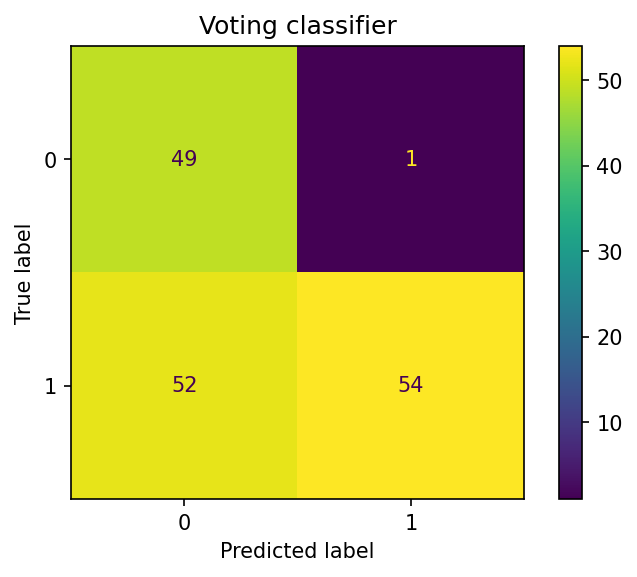

In [21]:
fig, ax = plt.subplots(dpi =150)
plot_confusion_matrix(vc,X_test, y_test, ax =ax)

ax.set_title('Voting classifier')

plt.show()

In [9]:
def apply_model(UF):    
    df = get_data_model(UF)

    features = ['srag_covid','diff_srag','trend','seasonal', 'susp_cli', 'conf_cli',  'susp_uti', 'conf_uti', 'trend_cases']
    df_m = pd.read_csv('max_lag_uf.csv', sep =';')
    df_m = df_m.loc[df_m.UF == UF]

    max_lag = df_m['max_lag'].values[0]

    T = 21 

    data = df[features]

    target_col = f'trend_{T}'

    df_lag = build_lagged_features(data, maxlag=max_lag)
    trend = [0 if t<=0 else 1 for t in np.sign(df_lag.srag_covid.shift(-T)-df_lag.srag_covid)]
    df_lag[f'trend_{T}'] = trend#makes down trend 0 
    df_lag = df_lag.dropna()
    target = df_lag[target_col].copy()

    del df_lag[target_col]

    X = df_lag
    y = target 

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, shuffle = False)

    automl = tune_model(X_train, y_train)

    lg = automl.best_model_for_estimator('lgbm')
    rf = automl.best_model_for_estimator('rf')
    et = automl.best_model_for_estimator('extra_tree')
    xg = automl.best_model_for_estimator('xgboost')

    vc = VotingClassifier(
    estimators=[('lgbm', lg),('RF',rf),('XT',et),('Xgboost',xg)],
    voting='soft',)

    vc.fit(X_train, y_train)
    
    y_pred = vc.predict(X_test)
    result = classification_report(y_test, y_pred, output_dict=True)

    return result['0']['recall'], result['1']['recall']